In [75]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## Data preparing and loading

In [76]:
#create known parameters
weight = 0.7
bias = 0.3

X = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = weight * X + bias
X[:10],y[:10],len(X),len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into train and test set (v.imp concept)

In [77]:
train_split = int(0.8*len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]
#can use scikitlearns train test split thats mentioned in my session notes
len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

In [78]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    #plots training data,test data and compares predictions
    plt.figure(figsize=(10,7))

    #plot training data in blue
    plt.scatter(train_data,train_labels,c='b',s=4,label="Training data")# c-> initial of color here its b for blue,s-> size,label->indexing of graph
    
    #plot test data in green
    plt.scatter(test_data,test_labels,c='g',s=4,label="Testing data")# c-> initial of color here its b for blue,s-> size,label->indexing of graph

    #are there predictions?
    if predictions is not None:
        #plot the predictions if they exist
        plt.scatter(test_data,predictions,c='r',s=4,label="Predictions")
    
    #show the legend
    plt.legend(prop={"size":14});


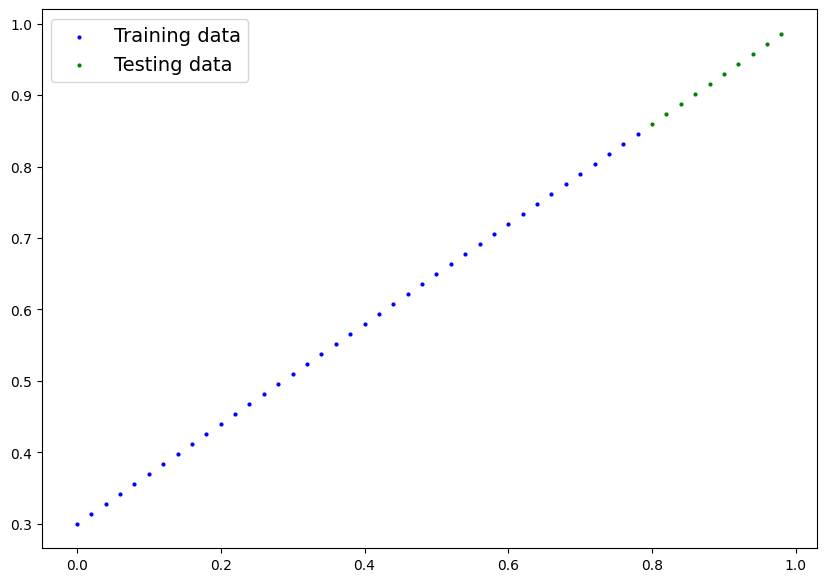

In [79]:
plot_predictions();

## Building the model

Our model is basically going to work, first by randomizing the parameters i.e weight and bias, and then look at training data and try to adjust the parameters to minimize the error. This is done by calculating the gradient of the error with respect to the parameters and then updating the parameters in the opposite direction of the gradient. This is repeated for a number of iterations.
The methods used for this are gradient descent and backpropagation.

In [80]:
#create linear regression model class
class LinearRegressionModel(nn.Module): # nn.Module -> is a base class and almost everything in Pytorch inherits from it.
    def __init__(self): # constructor 
        super().__init__() # this code means calling the construtor '__init__()' of the parent class i.e 'nn.Module' 
        # generating random parameters and assigning to the present instance of parameter with dtype of torch.float and requiring gradient descent (true is default)
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float)) 
        self.bias = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))

        #forward method to define the computation in the model
    def forward(self,x: torch.tensor) -> torch.Tensor: # <- "x" is the input data, here x:torch.tensor means the dtype of x, and -> torch.Tensor means the return type of function which is tensor.
        return self.weights * x + self.bias #linear regression formula


Now time to check our model 

In [81]:
#creating a manual seed
torch.manual_seed(42)
 
#creating an instance of our model
model_0= LinearRegressionModel()

#checking out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [82]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### making predictions using inference mode
we can check our model's predictive power by predicting y_test based on X_test.
and when we pass data through our model it will go through the forward method.

In [83]:
with torch.inference_mode(): # torch.inference_mode() is a context manager, that enables or disables inference mode which is a type of mechanism that can enable or disable gradients locally.
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [84]:
#lets compare it to y_test
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

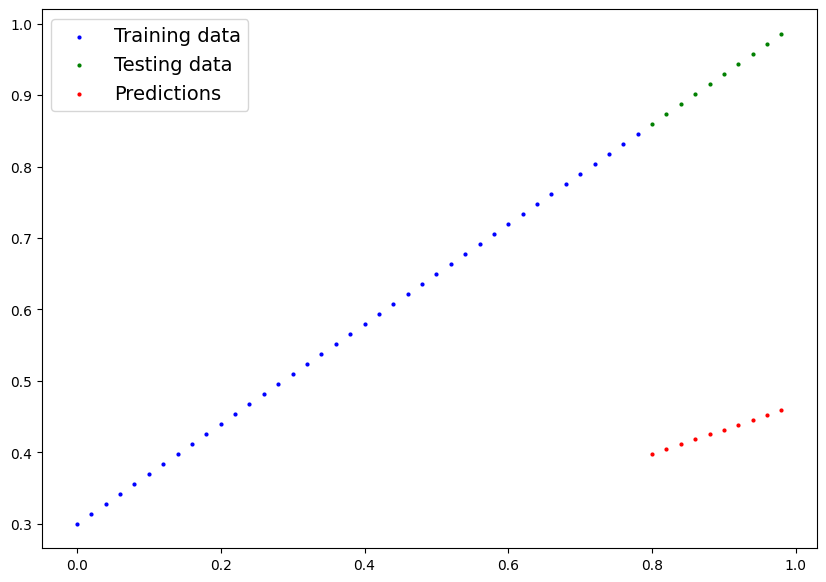

In [85]:
#lets visualize it,
plot_predictions(predictions=y_preds);
#for an ideal model the red data(predictions) will overlap with green data(test data).
#its far from ideal because initially our params are totally random and we work our way up by adjusting it.

## Training the model
* By training the model we move from unknown params to some known params.
* This can be done by loss function which calculates how poor our predictions is compared to an ideal data

Now we need to train two things, loss function and optimizer.
* Loss function measures our poor(ness) our model compared to ideal values.
* Optimizer adjusts the model's params by taking loss function into account.

In [86]:
# setting up a loss function
loss_fn = nn.L1Loss() #l1loss is mean absolute error, dont confuse it with mean squared error(mse)

# setting up an optimizer 
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01) #check out more about optimizer in torch.optim

* SGD (stochastic gradient descent algorithm) in case forgotten, check out gradient descent video by 3blue1brown. 
* syntax:torch.optim.<any optimizer>(arguments)
* lr:(learning rate) in simpler words, its the steepness of the descent towards the local minimum in the loss function. Higher the lr, higher will be the steepness. Lower the lr, lower the steepness. Possibly the most imp hyperparameter in training the model. Practically, lr defines how big/small the optimizer changes the parameter with each step.


### Building a training (and testing) loop
* looping through the data 
* forward pass
* calculate the loss
* optimizer zero grad
* loss backward (backpropagation)
* optimizer step

In [87]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [88]:
epochs = 200

#tracking different values
epoch_count =[]
loss_values=[]
test_loss_values=[]


# loop through the data 
for epoch in range(epochs):
    # setting the model to training mode
    model_0.train()

    # forward pass
    y_pred = model_0(X_train)

    # calculate the loss
    loss = loss_fn(y_pred,y_train)
    print(f'loss:{loss}')

    # optimizer zero grad
    optimizer.zero_grad()

    # perform back propagation on the loss with respect to the parameters of the model
    loss.backward()

    # optimizer step
    optimizer.step()

    #testing
    model_0.eval() # turns off different settings not needed for eval/testing.
    with torch.inference_mode(): # turns off gradient tracking cause we dont need those stuff while testing.
        # do the forward pass
        test_pred = model_0(X_test)

        #calculate the test loss
        test_loss = loss_fn(test_pred,y_test)

    #lets see whats happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch:{epoch}, Loss:{loss}, Test Loss:{test_loss}")
        #print out model state dict
        print(model_0.state_dict())
    

loss:0.31288138031959534
Epoch:0, Loss:0.31288138031959534, Test Loss:0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
loss:0.3013603389263153
loss:0.28983935713768005
loss:0.2783183455467224
loss:0.26679736375808716
loss:0.2552763521671295
loss:0.24375534057617188
loss:0.23223432898521423
loss:0.22071333229541779
loss:0.20919232070446014
loss:0.1976713240146637
Epoch:10, Loss:0.1976713240146637, Test Loss:0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
loss:0.18615034222602844
loss:0.1746293306350708
loss:0.16310831904411316
loss:0.1515873372554779
loss:0.14006635546684265
loss:0.1285453587770462
loss:0.11702437698841095
loss:0.1060912236571312
loss:0.09681284427642822
loss:0.08908725529909134
Epoch:20, Loss:0.08908725529909134, Test Loss:0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
loss:0.08227583020925522
loss:0.07638873159885406
loss:0.07160007208585739
loss:0

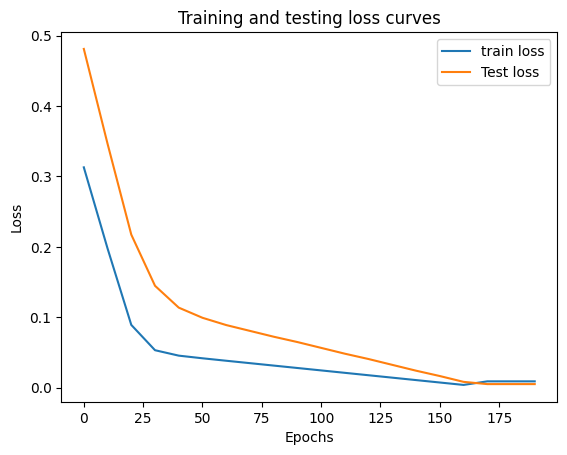

In [96]:
#plotting the loss curve
# plt.plot(epoch_count,loss_values,label="Train loss") this cant run cause the dtype of loss_values is tensor, we need to convert it to numpy array.
plt.plot(epoch_count,(torch.tensor(loss_values).numpy()),label="train loss")
plt.plot(epoch_count,test_loss_values,label="Test loss")
plt.title("Training and testing loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [90]:
model_0.state_dict(),weight,bias # we are trying to get the model value closer to the ideal values. 

(OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]),
 0.7,
 0.3)

In [91]:
with torch.inference_mode():
    y_preds_new=model_0(X_test)

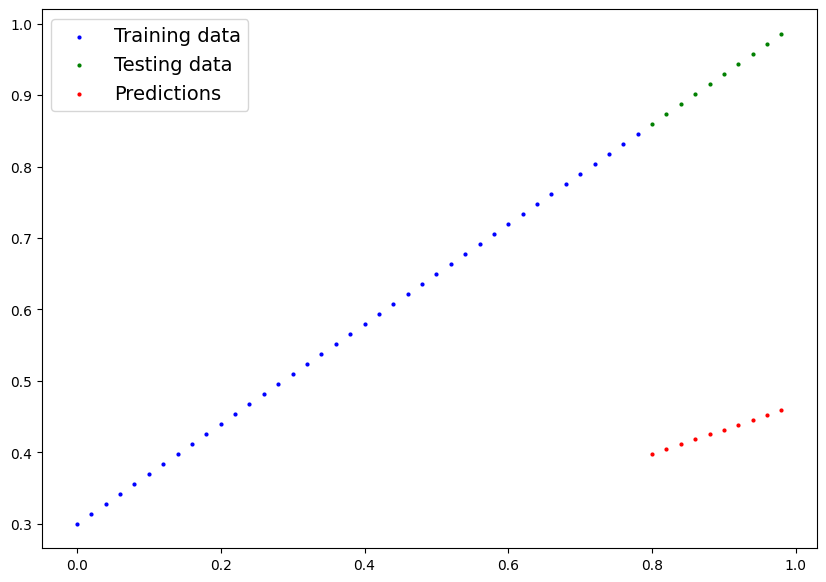

In [92]:
plot_predictions(predictions=y_preds); #before

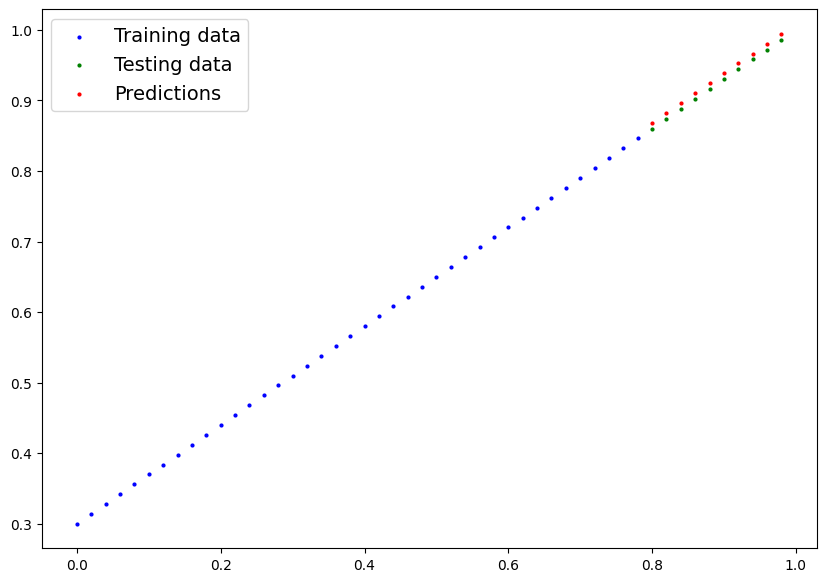

In [93]:
plot_predictions(predictions=y_preds_new); #after